In [7]:
# Importing dependencies
from IPython.display import Image, Audio
import scipy.io
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import mne

# Logistic regression classification of interaction with human and interaction with computer conditions

Successful social interactions rely on the abilities of two or more people to mutually exchange information in
real-time, while simultaneously adapting to one another. But the underlying neural mechanisms remain unknown. In an EEG experiment, we wanted to better understand the neural mechanisms when we engage in interaction with another person, versus with a computer. We thus aimed to predict whether the brain data (recorded with EEG) originated from an experimental condition where participants engaged in interaction with another person, or with a non-responsive computer. The participants were recruited in pairs, and asked to finger tap to a given beat, which would then cease, and they would hear either the other person (interacting with human), or the computer (interaction with computer). Their task was to sycnhronize with their auditory feedback (other person or computer). The other person was thus adaptable, while the computer was not. The computer condition in this experiment was also a metronome, thus not variable. The two experimental conditions are illustrated below.

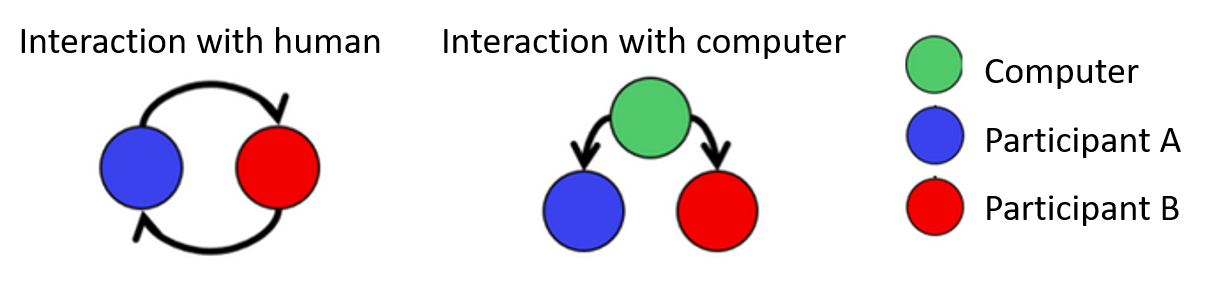

In [8]:
Image("conditions.png",width=700)

EEG data are known to be highly contaminated with noise (artefacts typically originating from muscle and eye movements). Therefore, the given EEG data are already pre-processed, and they represent the 10 Hz power estimates for each electrode (of each person in a pair) for each of the trials. The number of trials is the length of the vector $y$. Power is the squared value of the amplitude of the signal. The data contains power estimates from 60 EEG channels, where 30 belong to participant A and 30 to participant B. This gives a feature matrix $X$, with 60 columns (1 for each feature), and a length the same as the length of the vector $y$. The $y$ vector contains the labels for each trial (1 for the interaction with human condition, 0 for the interaction with computer condition). You have data from 4 pairs (features1.mat, features2.mat, features3.mat, features4.mat, and the corresponding $y$ vectors with condition labels).

In [9]:
# Loading features and labels
feature_mat = scipy.io.loadmat('features1.mat')
y1_mat = scipy.io.loadmat('y1.mat')
features1 = feature_mat['features1']
y1 = np.array(y1_mat['y1'].T[0])
print('The shape of the X feature matrix is: ' + str(features1.shape))
print('The shape of the y vector is: ' + str(y1.shape))

features_files = ['features1.mat', 'features2.mat', 'features3.mat', 'features4.mat']
label_files = ['y1.mat', 'y2.mat', 'y3.mat', 'y4.mat']

n_pairs = len(features_files)

features = []
labels = []

#load features and labels from all pairs
#we store them in lists, because they have different number of trials
for i,feature_f in enumerate(features_files):
    feature_map = scipy.io.loadmat(feature_f)
    y_mat = scipy.io.loadmat(label_files[i])
    idx = str(i+1)
    features.append(feature_map[f'features{idx}'])
    labels.append(np.array(y_mat[f'y{idx}'].T[0]))
    assert features[i].shape[0] == labels[i].shape[0] #ensure same n of trials and labels

The shape of the X feature matrix is: (1573, 60)
The shape of the y vector is: (1573,)


Your task is to predict the conditions of the trials from the EEG data (10 Hz power), using a logistic regression classification. This works by fitting a general linear model with a binomial cost and a logit link function. For additional explanation about the intuition of logistic regression see this [video](https://www.youtube.com/watch?v=yIYKR4sgzI8). The logistic regression classification is fitted with a selected subset of the 60 channels (the 30 channels from each member of the pair are grouped together here). The subset of channels are chosen with sequential feature selection. A 10-fold cross validation loop needs to be implemented as well to accurately assess how well the logistic regression model with sequential feature selection performs. 

#### Exercise 1
Your task is for each cross-validation fold to sequentially find the best number of features/channels and use  them to predict with the logistic regression model and calculate the training and test errors. Additionally, make sure to save the selected features in a list for later visualizations. Build-in functions for logistic regression and sequential feature selection in the scikit learn library might be helpful for your implementation.

##### The implementation step-by-step
> * Initially let's predefine some variables. `K = 10` as we want to divide the data into 10 folds. A variable `tol = 1e-6` which is the minimum improvement to the mean squared error (MSE) required to add an additional feature. Two arrays `test_MSE` and `train_MSE` to store the MSE for training and testing in each fold. We define the cross-validation strategy from `sklearn` as `CV = KFold(K,shuffle=True)` and finally an empty list `sfs_features` is defined to save the features found with sequential feature selection.

> * Now you need to set-up the cross-validation loop. Split the matrix `features1` and the vector `y1` into train and test sets using `CV.split`. For inspiration on how to do this see this [tutorial](https://riptutorial.com/scikit-learn/example/27963/k-fold-cross-validation). Furthermore, the `enumerate()` function might be helpful to keep a count variable of the fold number (e.g. `i`).

> * Use `train_index` and `test_index` from `CV.split()` to index the rows designated for test and training in `features1` and `y1` respectively.

> * Add an additional inner loop through the number of features (i.e. 60) and use [SequentialFeatureSelector()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) from `sklearn` to find the best features. Feed it [LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) as estimator and set `n_features_to_select` to the loop parameter (e.g. `j`). This way you can add one feature at a time and check if it causes an improvement greater than `tol`. A boolean with the best `j` parameters is found by fitting `SequentialFeatureSelector()` to the training data and then extracted with the methods `.get_support()`.

> * The logistic regression model LogisticRegression() is then fitted to the best features in the training data. This could be done as \
`model = LogisticRegression()` \
`model.fit(X_train[:,sfs.get_support()], y_train)` \
where `sfs` is your `SequentialFeatureSelector()`. 

> * Use your logistic regression model to predict and calculate the mean squared error (MSE) using [mean_squared_error() ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html). Now, break the loop if the improvement in the MSE is less than the `tol` variable. If the improvement in MSE is greater than `tol` update a variable storing the best MSE. This variable should be initialized outside the inner loop as an arbitrary large number for example as `best_MSE = 1e3`.

> * Lastly, save training and test MSE for each fold by using the features found with sequential feature selection. Append the boolean of the selected features to the `sfs_features` list. NB! You will need the `sfs_features` list for the exercises next week, where we will visualize and interpret the results.


In [14]:
# --- Step 1: Imports ---
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

# --- Step 2: Predefine variables ---
K = 10
tol = 1e-6
test_MSE = np.zeros(K)
train_MSE = np.zeros(K)
sfs_features = []

# Assume you already have:
# features1 -> shape (n_samples, 60)
# y1 -> binary vector (n_samples, )

CV = KFold(n_splits=K, shuffle=True, random_state=42)

# --- Step 3: Cross-validation loop ---
for i, (train_index, test_index) in enumerate(CV.split(features1)):
    X_train, X_test = features1[train_index], features1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]

    best_MSE = 1e3
    best_support = None

    # --- Step 4: Sequential feature selection loop ---
    for j in range(1, X_train.shape[1] + 1):
        model = LogisticRegression(max_iter=1000)

        # SFS: forward selection adding one feature at a time
        sfs = SequentialFeatureSelector(
            model,
            n_features_to_select=j,
            direction='forward',
            scoring='neg_mean_squared_error',
            cv=5,  # internal CV for feature selection
            n_jobs=-1
        )
        sfs.fit(X_train, y_train)

        # Fit logistic regression with selected features
        model.fit(X_train[:, sfs.get_support()], y_train)

        # Predictions
        y_train_pred = model.predict(X_train[:, sfs.get_support()])
        y_test_pred = model.predict(X_test[:, sfs.get_support()])

        # Compute MSE
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)

        # Check improvement
        if best_MSE - mse_test < tol:
            break
        else:
            best_MSE = mse_test
            best_support = sfs.get_support()

    # --- Step 5: Store best results for the fold ---
    sfs_features.append(best_support)
    train_MSE[i] = mse_train
    test_MSE[i] = mse_test

    print(f"Fold {i+1}: Best number of features = {sum(best_support)}, Train MSE = {mse_train:.4f}, Test MSE = {mse_test:.4f}")

# --- Step 6: Display results ---
print("\nAverage Train MSE:", np.mean(train_MSE))
print("Average Test MSE:", np.mean(test_MSE))

Fold 1: Best number of features = 4, Train MSE = 0.0989, Test MSE = 0.1013
Fold 2: Best number of features = 5, Train MSE = 0.0933, Test MSE = 0.1203
Fold 3: Best number of features = 4, Train MSE = 0.1011, Test MSE = 0.1013
Fold 4: Best number of features = 2, Train MSE = 0.1243, Test MSE = 0.1146
Fold 5: Best number of features = 4, Train MSE = 0.0953, Test MSE = 0.1019
Fold 6: Best number of features = 5, Train MSE = 0.0960, Test MSE = 0.1338
Fold 7: Best number of features = 5, Train MSE = 0.0953, Test MSE = 0.0955
Fold 8: Best number of features = 7, Train MSE = 0.0946, Test MSE = 0.0573
Fold 9: Best number of features = 3, Train MSE = 0.1116, Test MSE = 0.0828
Fold 10: Best number of features = 5, Train MSE = 0.0953, Test MSE = 0.1210

Average Train MSE: 0.10058568405501986
Average Test MSE: 0.10297911795533339


#### Exercise Part 2

To get a better overview of which features are selected in each cross-validation fold a matrix plot with a row for each feature and a column for each cross-validation fold can be useful.

Plot a matrix of the selected features for each cross validation fold. If there is time, do this for all 4 pairs. 

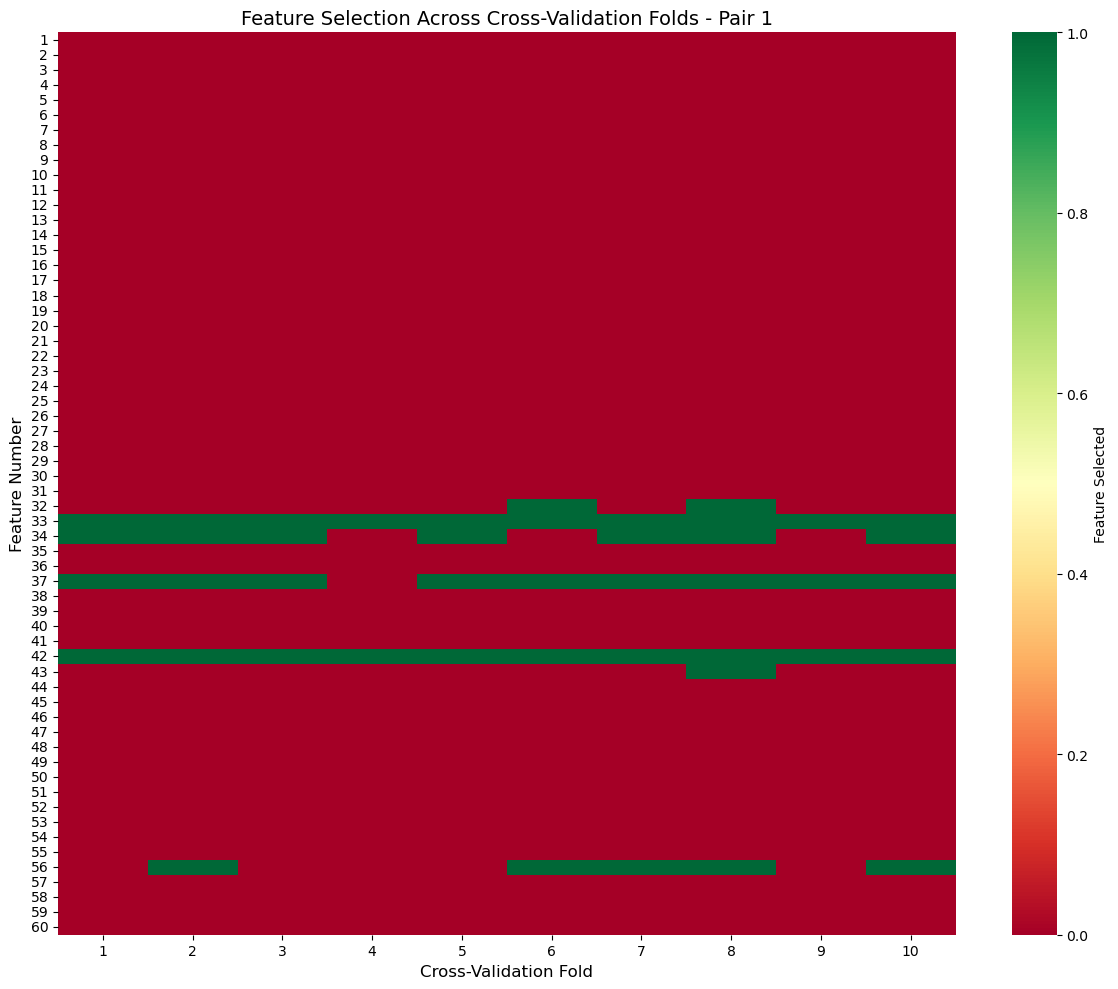


Feature Selection Summary:
Features selected in all folds: [33 42]
Features selected in >50% of folds: [33 34 37 42]

Selection frequency per feature:
Feature 32: selected in 2/10 folds (20.0%)
Feature 33: selected in 10/10 folds (100.0%)
Feature 34: selected in 7/10 folds (70.0%)
Feature 37: selected in 9/10 folds (90.0%)
Feature 42: selected in 10/10 folds (100.0%)
Feature 43: selected in 1/10 folds (10.0%)
Feature 56: selected in 5/10 folds (50.0%)


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exercise 2: Plot matrix of selected features for each CV fold

# Convert the list of boolean arrays to a 2D numpy array
# Each column represents a fold, each row represents a feature
sfs_matrix = np.array(sfs_features).T  # Transpose to get features as rows

# Create the plot
plt.figure(figsize=(12, 10))
sns.heatmap(sfs_matrix, 
            cmap='RdYlGn',  # Red-Yellow-Green colormap
            cbar_kws={'label': 'Feature Selected'},
            yticklabels=range(1, 61),  # Feature numbers 1-60
            xticklabels=range(1, K+1))  # Fold numbers 1-K

plt.xlabel('Cross-Validation Fold', fontsize=12)
plt.ylabel('Feature Number', fontsize=12)
plt.title('Feature Selection Across Cross-Validation Folds - Pair 1', fontsize=14)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nFeature Selection Summary:")
print(f"Features selected in all folds: {np.where(sfs_matrix.sum(axis=1) == K)[0] + 1}")
print(f"Features selected in >50% of folds: {np.where(sfs_matrix.sum(axis=1) > K/2)[0] + 1}")
print(f"\nSelection frequency per feature:")
selection_freq = sfs_matrix.sum(axis=1)
for idx, freq in enumerate(selection_freq):
    if freq > 0:
        print(f"Feature {idx+1}: selected in {freq}/{K} folds ({freq/K*100:.1f}%)")


Processing Pair 1...

Processing Pair 2...

Processing Pair 3...

Processing Pair 4...


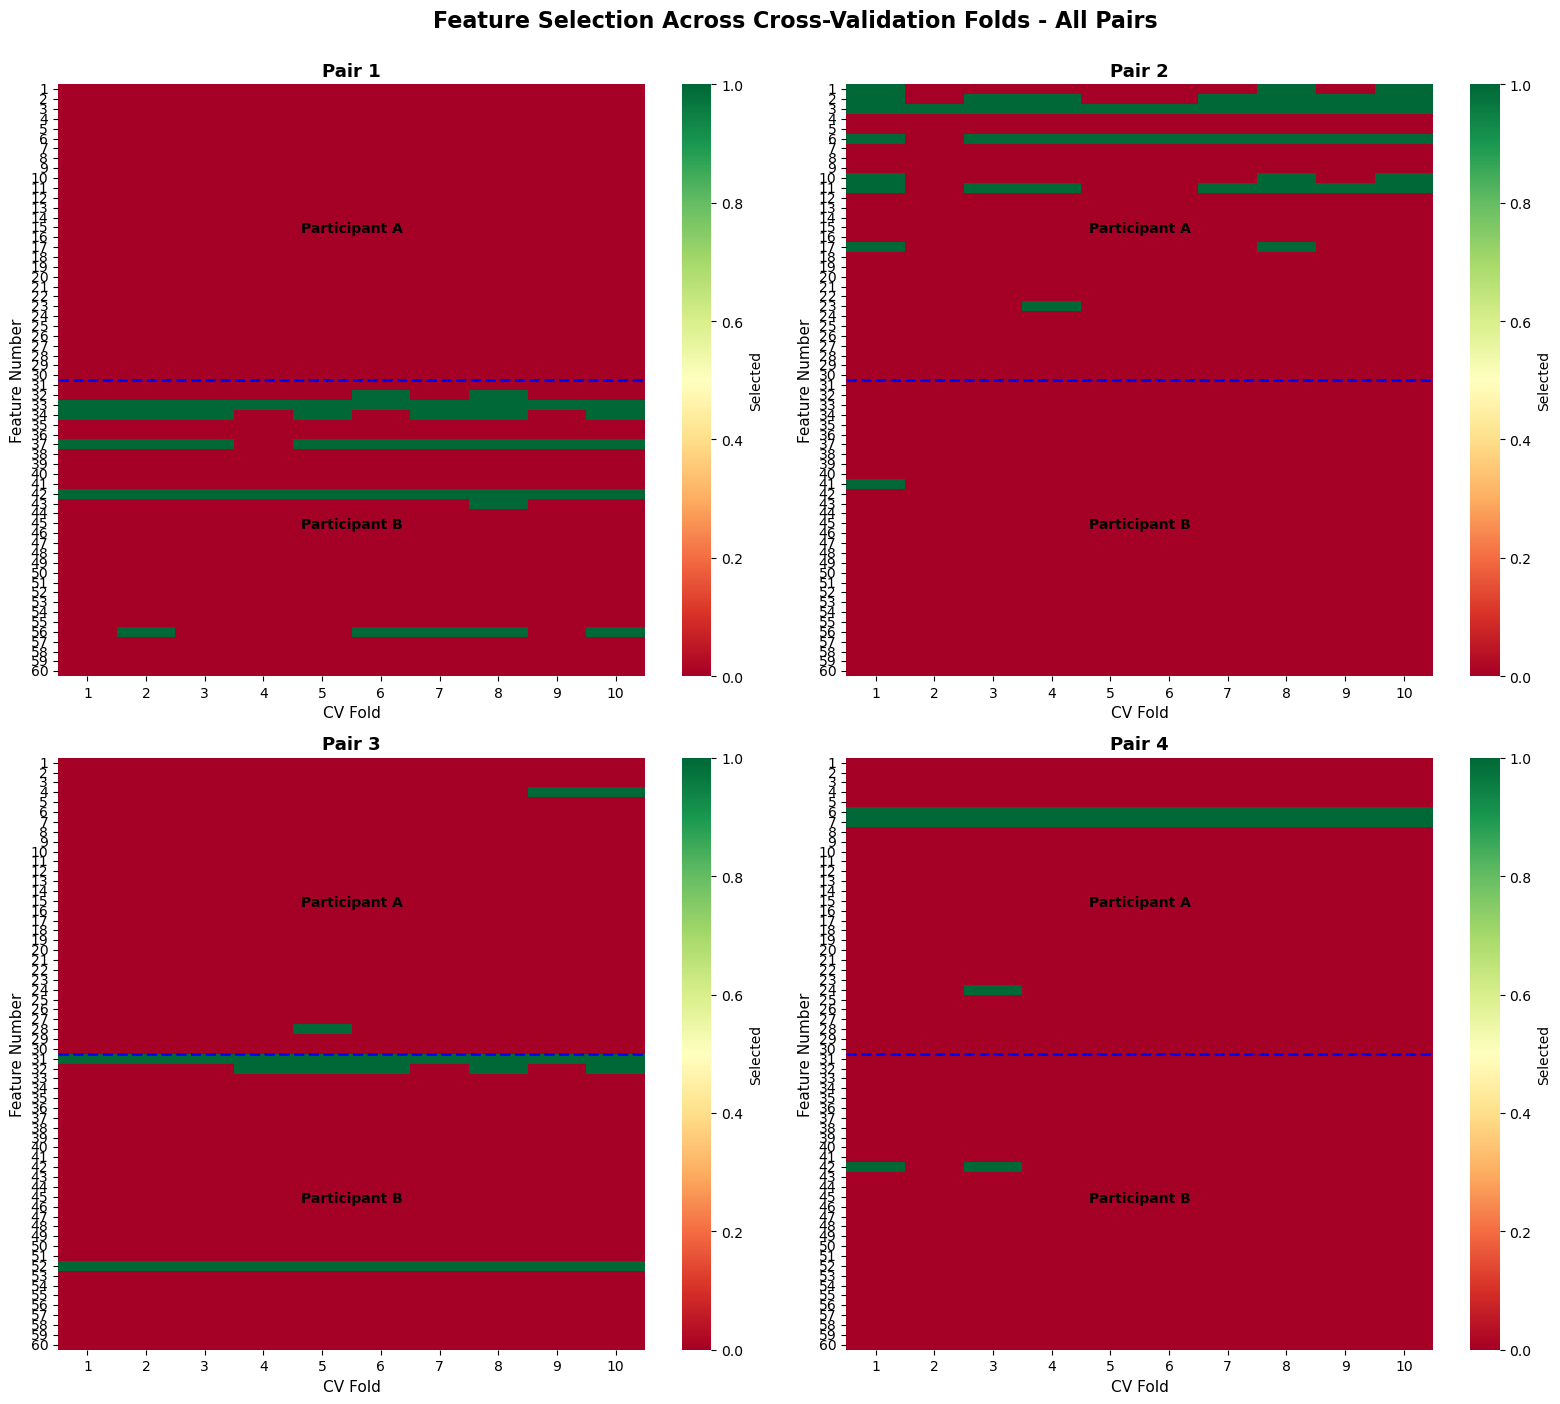


PAIR 1 SUMMARY

Total selections - Participant A: 0
Total selections - Participant B: 44

Most frequently selected features (>50% of folds):
  Feature 33 (Participant B): 10/10 folds (100.0%)
  Feature 34 (Participant B): 7/10 folds (70.0%)
  Feature 37 (Participant B): 9/10 folds (90.0%)
  Feature 42 (Participant B): 10/10 folds (100.0%)

PAIR 2 SUMMARY

Total selections - Participant A: 42
Total selections - Participant B: 1

Most frequently selected features (>50% of folds):
  Feature 2 (Participant A): 7/10 folds (70.0%)
  Feature 3 (Participant A): 10/10 folds (100.0%)
  Feature 6 (Participant A): 9/10 folds (90.0%)
  Feature 11 (Participant A): 7/10 folds (70.0%)

PAIR 3 SUMMARY

Total selections - Participant A: 3
Total selections - Participant B: 25

Most frequently selected features (>50% of folds):
  Feature 31 (Participant B): 10/10 folds (100.0%)
  Feature 52 (Participant B): 10/10 folds (100.0%)

PAIR 4 SUMMARY

Total selections - Participant A: 21
Total selections - Part

In [16]:
# Exercise 2: Plot for all 4 pairs

# First, we need to run the cross-validation for all pairs
all_sfs_features = []  # Store results for all pairs

for pair_idx in range(n_pairs):
    print(f"\nProcessing Pair {pair_idx + 1}...")
    
    X = features[pair_idx]
    y = labels[pair_idx]
    
    pair_sfs_features = []
    
    for i, (train_index, test_index) in enumerate(CV.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        best_MSE = 1e3
        best_support = None
        
        for j in range(1, X_train.shape[1] + 1):
            model = LogisticRegression(max_iter=1000)
            
            sfs = SequentialFeatureSelector(
                model,
                n_features_to_select=j,
                direction='forward',
                scoring='neg_mean_squared_error',
                cv=5,
                n_jobs=-1
            )
            sfs.fit(X_train, y_train)
            
            model.fit(X_train[:, sfs.get_support()], y_train)
            
            y_test_pred = model.predict(X_test[:, sfs.get_support()])
            mse_test = mean_squared_error(y_test, y_test_pred)
            
            if best_MSE - mse_test < tol:
                break
            else:
                best_MSE = mse_test
                best_support = sfs.get_support()
        
        pair_sfs_features.append(best_support)
    
    all_sfs_features.append(pair_sfs_features)

# Now plot all 4 pairs
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for pair_idx in range(n_pairs):
    sfs_matrix = np.array(all_sfs_features[pair_idx]).T
    
    sns.heatmap(sfs_matrix, 
                ax=axes[pair_idx],
                cmap='RdYlGn',
                cbar_kws={'label': 'Selected'},
                yticklabels=range(1, 61),
                xticklabels=range(1, K+1))
    
    axes[pair_idx].set_xlabel('CV Fold', fontsize=11)
    axes[pair_idx].set_ylabel('Feature Number', fontsize=11)
    axes[pair_idx].set_title(f'Pair {pair_idx + 1}', fontsize=13, fontweight='bold')
    
    # Add separation line between participant A and B features
    axes[pair_idx].axhline(y=30, color='blue', linewidth=2, linestyle='--')
    axes[pair_idx].text(K/2, 15, 'Participant A', ha='center', fontweight='bold')
    axes[pair_idx].text(K/2, 45, 'Participant B', ha='center', fontweight='bold')

plt.suptitle('Feature Selection Across Cross-Validation Folds - All Pairs', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print summary for all pairs
for pair_idx in range(n_pairs):
    print(f"\n{'='*50}")
    print(f"PAIR {pair_idx + 1} SUMMARY")
    print(f"{'='*50}")
    
    sfs_matrix = np.array(all_sfs_features[pair_idx]).T
    selection_freq = sfs_matrix.sum(axis=1)
    
    # Separate by participant
    participant_A_freq = selection_freq[:30].sum()
    participant_B_freq = selection_freq[30:].sum()
    
    print(f"\nTotal selections - Participant A: {participant_A_freq}")
    print(f"Total selections - Participant B: {participant_B_freq}")
    
    print(f"\nMost frequently selected features (>50% of folds):")
    frequent_features = np.where(selection_freq > K/2)[0] + 1
    for feat in frequent_features:
        freq = selection_freq[feat-1]
        participant = 'A' if feat <= 30 else 'B'
        print(f"  Feature {feat} (Participant {participant}): {freq}/{K} folds ({freq/K*100:.1f}%)")

#### Conclusions based on the results

From the matrix plot we can see that some features are selected in every (or almost every) cross-validation fold, whereas others are more randomly selected. 

The list of the corresponding electrodes from 1-30 (for each person) is as follows: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, C4, T8, TP9, CP5, CP1, CP2, CP6, TP10, P7, P3, Pz, P4, P8, O1, Oz, O2.
"F" refers to frontal electrodes; "T" = temporal; "C" = central; "P" = parietal; "O" = occipital; "FC" = fronto-central, etc. 

Looking at the matrices of selected features, do one participant's features seem to be more important for the prediction than the other's? 

Where are the most selected features situated?

In this experiment, in each pair one participant emerged as a leader and the other as a follower during the human-interaction. However, in the computer condition, each of the participants followed the computer. The participant in each pair whose features seem to be more important for the prediction was always the leader of the human-interaction. We speculate that the selected features thus tell us something about the neural mechanisms underlying leading behaviour. The follower participant is following in both the human and computer conditions, hence there is less difference in 10 Hz power modulation between the two conditions for this participant. The leading participant, however, follows the computer in the computer-condition, but focuses more on self-generated taps in the human-condition - hence emerging as a "leader" in the interaction.

What can you thus conclude about the neural mechanisms underlying leading behaviour, based on the selected features? 


### Conclusions from the Results

**1. Do one participant's features seem to be more important?**

Yes, in each pair, the features from one participant are far more predictive than the other. The features are split so that **1-30 are Participant A** and **31-60 are Participant B**.

* **Pair 1:** Participant **B**'s features were overwhelmingly selected (44 total selections vs. 0 for A).
* **Pair 2:** Participant **A**'s features were selected (42 total selections vs. 1 for B).
* **Pair 3:** Participant **B**'s features were selected (25 total selections vs. 3 for A).
* **Pair 4:** Participant **A**'s features were selected (21 total selections vs. 2 for B).

The "more important" participant, according to the notebook, was the one who emerged as the **leader** in the human-interaction condition.

**2. Where are the most selected features situated?**

The most consistently selected features (those chosen in >50% of the cross-validation folds) are almost all located in the **frontal ("F") and fronto-central ("FC")** regions of the brain.

If we map the most frequent features from your summary to the electrode list provided:
* **Fp1/Fp2** (Fronto-polar): Features 2, 31
* **F3/F4/F7/F8/Fz** (Frontal): Features 3, 6, 7, 33, 34, 37
* **FC6** (Fronto-central): Feature 11

**3. What can you conclude about the neural mechanisms of leading behaviour?**

The notebook explains that the "leader" was the only one *changing* their strategy between conditions (leading in the human task, following in the computer task), while the "follower" was *always* following.

Therefore, the model is picking up on the brain activity that differentiates "leading" from "following."

**Conclusion:** Based on the selected features, you can conclude that this "leading" behavior (focusing on self-generated action vs. synchronizing to an external source) is characterized by a significant and detectable change in **10 Hz power within the frontal and fronto-central lobes** of the brain.